# PneumoScope Project Notebook
**Author**: Ali Hussain  
**Course**: Deep-Learning, AI23, IT-Högskolan Göteborg  

## Overview
This Jupyter Notebook demonstrates:

- Exploratory Data Analysis (EDA) on a chest X-ray dataset.
- Training of two classification models:
  1. **Binary** (Normal vs. Pneumonia)
  2. **Multiclass** (Normal vs. Bacteria vs. Virus)

We import custom scripts (e.g., `train.py`, `train_multiclass.py`) to train and evaluate the models:

- **Binary**: Evaluate with metrics (precision, recall, F1, accuracy, AUC) using `evaluate.py`.
- **Multiclass**: Evaluate with macro-F1, confusion matrix, etc., using `evaluate_multiclass.py`.

We also discuss:

- Potential data leakage issues and how to mitigate them.
- Differences between binary and multiclass performance, overfitting vs. underfitting, and how ResNet18 interacts with this dataset.
- The main scripts involved:
  - `reorganize_dataset.py` (data splitting)
  - `train.py` / `train_multiclass.py` (training loops)
  - `evaluate.py` / `evaluate_multiclass.py` (evaluations)
  - `data_loader.py` (augmentations, weighted sampling)
  - `model.py` (ResNet-based architectures)

Finally, we delve into potential improvements such as hyperparameter tuning, more robust data handling, and alternative architectures.


In [2]:
# Environment Setup & Imports

# If you want to install dependencies in this notebook environment, you could uncomment:
# %pip install -r requirements.txt

import os
import sys
import json
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from IPython.display import display, Markdown

import torch
import torchvision.transforms as transforms

# Assume this notebook is in the project root folder (PneumoScope/).
PROJECT_ROOT = os.getcwd()
SRC_PATH = os.path.join(PROJECT_ROOT, "src")

# Ensure the "src" directory is in sys.path for custom modules
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

# Import custom modules
from kaggle_downloader import download_dataset_if_needed
from reorganize_dataset import reorganize_dataset
from train import train_model
from evaluate import evaluate_model
from train_multiclass import train_model_multiclass
from evaluate_multiclass import evaluate_model_multiclass
from model import PneumoNet
from train_multiclass import PneumoNetMulti

print("Environment ready. Using Python path:", sys.path)


Environment ready. Using Python path: ['c:\\Dev\\PneumoScope\\src', 'C:\\Users\\alica\\AppData\\Local\\Programs\\Python\\Python310\\python310.zip', 'C:\\Users\\alica\\AppData\\Local\\Programs\\Python\\Python310\\DLLs', 'C:\\Users\\alica\\AppData\\Local\\Programs\\Python\\Python310\\lib', 'C:\\Users\\alica\\AppData\\Local\\Programs\\Python\\Python310', 'c:\\Dev\\PneumoScope\\.venv', '', 'c:\\Dev\\PneumoScope\\.venv\\lib\\site-packages', 'c:\\Dev\\PneumoScope\\.venv\\lib\\site-packages\\win32', 'c:\\Dev\\PneumoScope\\.venv\\lib\\site-packages\\win32\\lib', 'c:\\Dev\\PneumoScope\\.venv\\lib\\site-packages\\Pythonwin']


### Core Components
- **main.py**  
  Orchestrates the entire pipeline (checks data folders, downloads if needed).  
  Reorganizes the dataset for both binary and multiclass tasks.  
  Trains and evaluates both models sequentially.

- **reorganize_dataset.py**  
  Splits the raw dataset into `train/`, `val/`, and `test/` subfolders.  
  Moves all images into a temporary folder, then re-splits using given proportions (15% val, 15% test, 70% train).  
  Organizes data for binary (NORMAL vs. PNEUMONIA) and multiclass (NORMAL, BACTERIA, VIRUS).

- **train.py & evaluate.py** (binary)  
  Implements training and evaluation loops, using BCEWithLogitsLoss for binary classification.

- **train_multiclass.py & evaluate_multiclass.py**  
  Similar but for three classes (Normal, Bacteria, Virus). Uses CrossEntropyLoss.

- **data_loader.py**  
  Builds DataLoaders, handles data augmentation, WeightedRandomSampler, etc.

- **model.py**  
  Defines `PneumoNet` (binary) and `PneumoNetMulti` (multiclass, though currently in `train_multiclass.py`), both based on ResNet18.


In [3]:
# Dataset Preparation & Potential Data Leakage

# Directory settings
data_dir = os.path.join(PROJECT_ROOT, "data")
data_multi_dir = os.path.join(PROJECT_ROOT, "data_multi")

# 1) If train/val/test do not exist, download dataset from Kaggle
if not (os.path.exists(os.path.join(data_dir, "train")) and
        os.path.exists(os.path.join(data_dir, "val")) and
        os.path.exists(os.path.join(data_dir, "test"))):
    print("[NOTEBOOK] Data directories not found. Downloading from Kaggle...")
    download_dataset_if_needed()
else:
    print("[NOTEBOOK] 'train/', 'val/', and 'test/' already exist. Skipping Kaggle download.")

# 2) If data_multi/ is missing, reorganize dataset for binary & multiclass
if not os.path.exists(data_multi_dir):
    print("[NOTEBOOK] 'data_multi/' not found. Reorganizing data...")
    reorganize_dataset(data_dir=data_dir)
else:
    print("[NOTEBOOK] 'data_multi/' already exists. Skipping reorganize_dataset.")


[NOTEBOOK] 'train/', 'val/', and 'test/' already exist. Skipping Kaggle download.
[NOTEBOOK] 'data_multi/' already exists. Skipping reorganize_dataset.


### Potential Data Leakage

- **Same patient in multiple splits:**  
  The model could learn patient-specific artifacts.  
  **Mitigation**: Use patient-level metadata to ensure each patient is only in one split.

- **Extra text/stamps in images:**  
  Some X-rays contain hospital names or letters like "R."  
  **Mitigation**: Crop around the lung region, or mask any stamps.

- **Filenames containing class info:**  
  Example: Filenames with "bacteria" or "virus."  
  **Mitigation**: Rename or randomize filenames, shuffle data.

- **Order-based leakage:**  
  If shuffle=False, alphabetical sorting might expose patterns.  
  **Mitigation**: Shuffle sets or use fixed random seeds.


Found 1109 normal images in train
Found 1946 bacteria and 1047 virus in train
Found 237 normal images in val
Found 417 bacteria and 223 virus in val
Found 237 normal images in test
Found 417 bacteria and 223 virus in test


### Distribution of NORMAL, BACTERIA, and VIRUS in 'data/'

Image Count
Set   Type                 
train normal           1109
      bacteria         1946
      virus            1047
val   normal            237
      bacteria          417
      virus             223
test  normal            237
      bacteria          417
      virus             223

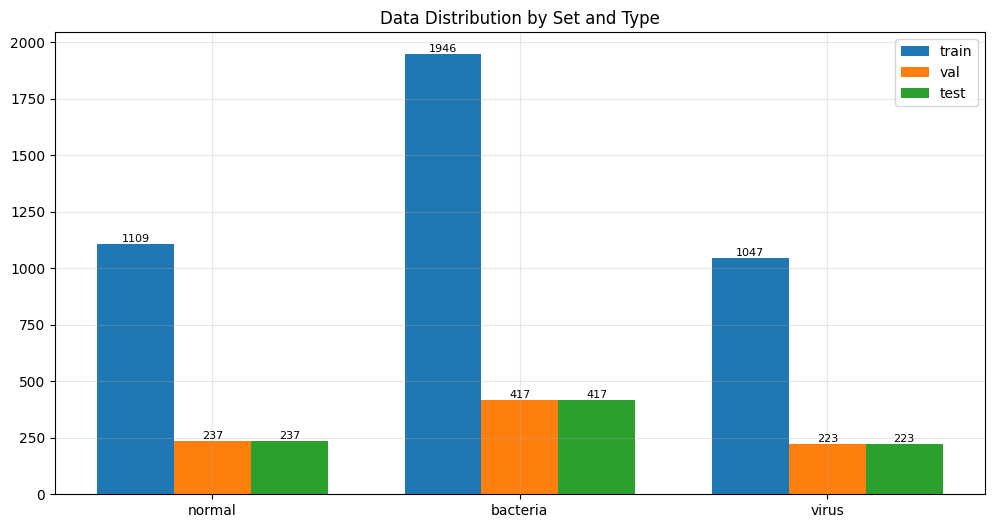

In [5]:
# Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np

def count_images_by_type(base_path):
    """
    Count how many NORMAL, BACTERIA, and VIRUS images exist 
    in each split (train, val, test).
    """
    from collections import Counter
    counts = Counter()
    for dataset_type in ['train','val','test']:
        dataset_path = os.path.join(base_path, dataset_type)
        if not os.path.exists(dataset_path):
            print(f"[WARN] {dataset_type} path does not exist: {dataset_path}")
            continue
        
        for label in ['NORMAL','PNEUMONIA']:
            label_path = os.path.join(dataset_path, label)
            if not os.path.exists(label_path):
                print(f"[WARN] {label} path not found: {label_path}")
                continue
            
            if label == 'NORMAL':
                count_normal = len(os.listdir(label_path))
                counts[(dataset_type, 'normal')] += count_normal
                print(f"Found {count_normal} normal images in {dataset_type}")
            else:
                # PNEUMONIA => split into bacteria/virus
                bacteria_count, virus_count = 0, 0
                for image_name in os.listdir(label_path):
                    if 'bacteria' in image_name.lower():
                        bacteria_count += 1
                    elif 'virus' in image_name.lower():
                        virus_count += 1
                counts[(dataset_type, 'bacteria')] += bacteria_count
                counts[(dataset_type, 'virus')] += virus_count
                print(f"Found {bacteria_count} bacteria and {virus_count} virus in {dataset_type}")
    return counts

base_dir_for_eda = data_dir
image_counts = count_images_by_type(base_dir_for_eda)

df_counts = pd.DataFrame.from_dict(image_counts, orient='index', columns=['Image Count'])
df_counts.index = pd.MultiIndex.from_tuples(df_counts.index, names=["Set", "Type"])

display(Markdown("### Distribution of NORMAL, BACTERIA, and VIRUS in 'data/'"))
display(df_counts)

# Bar plot for distribution
plt.figure(figsize=(12,6))
df_reset = df_counts.reset_index()
categories = ['normal', 'bacteria', 'virus']
x_indices = np.arange(len(categories))
width = 0.25

for i, subset_type in enumerate(['train','val','test']):
    subset = df_reset[df_reset['Set'] == subset_type]
    type_counts = {row['Type']: row['Image Count'] for _, row in subset.iterrows()}
    y_values = [type_counts.get(t, 0) for t in categories]
    x_offset = x_indices + i * width
    
    bars = plt.bar(x_offset, y_values, width=width, label=subset_type)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}',
                 ha='center', va='bottom', fontsize=8)

plt.title("Data Distribution by Set and Type")
plt.xticks(x_indices + width, categories)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


### Inspecting Sample Images
Below is a function to display a few random examples from `train/` subfolders (NORMAL, PNEUMONIA/Bacteria, PNEUMONIA/Virus).


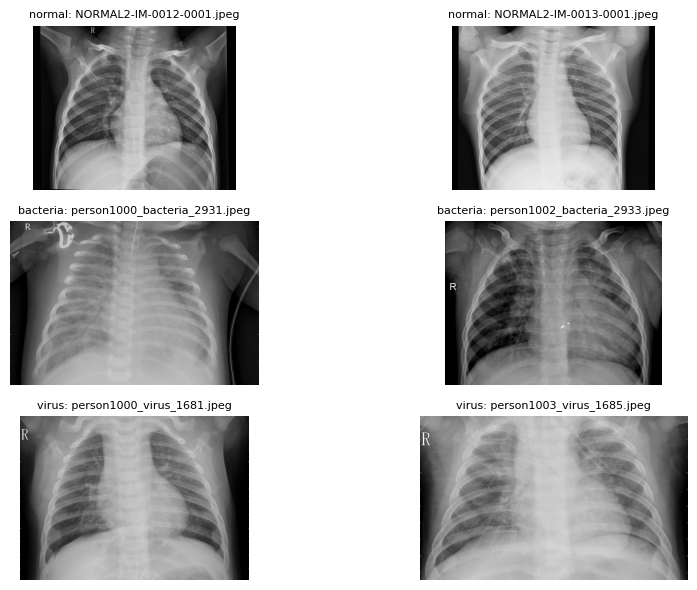

In [6]:
from PIL import Image

def display_sample_images(base_path, num_samples=2):
    categories = [
        ('NORMAL', 'normal'),
        ('PNEUMONIA', 'bacteria'),
        ('PNEUMONIA', 'virus')
    ]
    fig, axes = plt.subplots(len(categories), num_samples, figsize=(10, 6))
    
    for i, (folder, label_part) in enumerate(categories):
        folder_path = os.path.join(base_path, 'train', folder)
        if not os.path.exists(folder_path):
            continue
        
        images = [f for f in os.listdir(folder_path) if label_part in f.lower()][:num_samples]
        
        for j, img_name in enumerate(images):
            img_path = os.path.join(folder_path, img_name)
            with Image.open(img_path).convert('L') as im_:
                axes[i, j].imshow(im_, cmap='gray')
                axes[i, j].set_title(f"{label_part}: {img_name}", fontsize=8)
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

display_sample_images(base_dir_for_eda)


## TRAINING & EVALUATION – BINARY CLASSIFICATION
Below, we call `train_model()` from `train.py` to train a ResNet18-based binary classifier (NORMAL vs. PNEUMONIA). Hyperparameters are set to minimal values for a quick training demonstration (eg. epochs=1 etc).

The real hyperparameters used during the "long" training where:

```python
HYPERPARAMETERS = {
    'epochs': 30,              # Maximum number of epochs
    'learning_rate': 0.001,    # Initial learning rate for Adam optimizer
    'patience': 5,             # Early stopping patience
    'use_amp': True,           # Use Automatic Mixed Precision (AMP)
    
    'batch_size': 32,          # Number of samples per batch
    'num_workers': max(1, os.cpu_count() - 1),  # DataLoader workers
    'balance_train': True,     # Use balanced sampling for training
    'augment_train': True,     # Use data augmentation
    'random_crop': True,       # Apply random cropping
    'color_jitter': True,      # Apply color jittering
    'desired_total_samples': None,  # Target number of samples (None for all)
    
    'monitor': 'val_auc',      # Metric to monitor for early stopping
    'monitor_mode': 'max',     # 'min' for loss, 'max' for metrics
}
```

- **Epochs**: The maximum number of training epochs was set to 30.
- **Learning Rate**: The initial learning rate for the Adam optimizer was set to 0.001.
- **Patience**: Early stopping was configured with a patience of 5 epochs, meaning training would stop if the monitored metric did not improve for 5 consecutive epochs.
- **Automatic Mixed Precision (AMP)**: AMP was enabled to speed up training and reduce memory usage.
- **Batch Size**: The batch size was set to 32 samples per batch.
- **DataLoader Workers**: The number of workers for data loading was set to the number of CPU cores minus one.
- **Balanced Sampling**: Balanced sampling was used to ensure an equal representation of classes in each batch.
- **Data Augmentation**: Data augmentation techniques such as random cropping and color jittering were applied to the training data to improve generalization.
- **Early Stopping**: The validation AUC (Area Under the ROC Curve) was monitored for early stopping, with the mode set to 'max' to stop training when the AUC stopped improving.

In [7]:
binary_save_dir = os.path.join(PROJECT_ROOT, "saved_models")
binary_results_dir = os.path.join(PROJECT_ROOT, "results")

print("[NOTEBOOK] Starting training (BINARY)...")

model_bin, best_bin_path, logs_bin_path = train_model(
    data_dir=data_dir,
    save_dir=binary_save_dir,
    results_dir=binary_results_dir
)

print("\n[NOTEBOOK] Binary training complete.")
print("Best model saved at:", best_bin_path)
print("Training logs saved at:", logs_bin_path)


[NOTEBOOK] Starting training (BINARY)...
[INFO] Using device: cuda
GPU: Quadro T2000 with Max-Q Design
cuDNN Enabled: True
cuDNN Benchmark Mode: True

GPU Memory Usage:
GPU 0: Quadro T2000 with Max-Q Design
  Allocated: 0.0MB
  Cached:    0.0MB

[INFO] Training with hyperparameters:
  epochs: 1
  learning_rate: 0.001
  patience: 1
  use_amp: True
  batch_size: 32
  num_workers: 15
  balance_train: False
  augment_train: False
  random_crop: False
  color_jitter: False
  desired_total_samples: None
  monitor: val_auc
  monitor_mode: max

[INFO] Starting training with:
  Monitor metric: val_auc
  Monitor mode: max
  Patience: 1

[INFO] Starting training...

=== Epoch 1/1 ===


[INFO] Checkpoint saved: c:\Dev\PneumoScope\saved_models\checkpoint_e01_val_auc0.9958_20250119-144839.pth

[INFO] val_auc improved to 0.9958
[INFO] Saved checkpoint: c:\Dev\PneumoScope\saved_models\checkpoint_e01_val_auc0.9958_20250119-144839.pth
[INFO] Updated best model: c:\Dev\PneumoScope\saved_models\best_model_20250119-144839.pth

Metrics for epoch 1:
Training:
  Loss: 0.1997
  Precision: 0.9442
  Recall: 0.9602
  F1-score: 0.9521
  Accuracy: 0.9295
  AUC: 0.9664
  Confusion Matrix:
[[ 939  170]
 [ 119 2874]]

Validation:
  Loss: 0.0916
  Precision: 0.9738
  Recall: 0.9859
  F1-score: 0.9798
  Accuracy: 0.9704
  AUC: 0.9958
  Confusion Matrix:
[[220  17]
 [  9 631]]

[INFO] Training completed!
[INFO] Final training logs saved to: c:\Dev\PneumoScope\results\training_logs_e01_b32_20250119-144839.json

[NOTEBOOK] Binary training complete.
Best model saved at: c:\Dev\PneumoScope\saved_models\best_model_20250119-144839.pth
Training logs saved at: c:\Dev\PneumoScope\results\training_log

### Interesting Code Aspects in `train.py`

- **Balanced Sampling**: If `balance_train=True`, a `WeightedRandomSampler` can oversample minority classes.  
- **Automatic Mixed Precision (AMP)**: `use_amp=True` can speed up training on GPUs.  
- **Early Stopping**: By default, it monitors `val_auc`.  
- **Model Architecture**: ResNet18 with a single logit output for binary classification.  
- **Why AUC for Binary?**  
  AUC is more robust under class imbalance and measures ranking capability. One could also monitor `val_f1` or `val_loss`.

Below, we evaluate the best model:


In [8]:
print("[NOTEBOOK] Evaluating the best binary model...")

precision, recall, f1, accuracy, auc_score, avg_precision = evaluate_model(
    model_path=best_bin_path,
    data_dir=data_dir,
    results_dir=binary_results_dir
)

print(f"\n[BINARY] Precision={precision:.4f}, Recall={recall:.4f}, "
      f"F1={f1:.4f}, Accuracy={accuracy:.4f}, AUC={auc_score:.4f}, Avg Precision={avg_precision:.4f}")


[NOTEBOOK] Evaluating the best binary model...
[INFO] Evaluating model: best_model_20250119-144839
[INFO] Results will be saved to: c:\Dev\PneumoScope\results


c:\Dev\PneumoScope\src\evaluate.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
Evaluating: 100%|██████████| 7/


[INFO] Evaluation Results for best_model_20250119-144839:
Confusion Matrix:
[[203  34]
 [  9 631]]
Precision: 0.9489
Recall:    0.9859
F1-score:  0.9670
Accuracy:  0.9510
AUC-ROC:   0.9908
PR-AUC:    0.9965
Avg Precision: 0.9965

Per-class metrics:
NORMAL:
  Precision: 0.8565
  Recall:    0.9575
  F1-score:  0.9042
PNEUMONIA:
  Precision: 0.9859
  Recall:    0.9489
  F1-score:  0.9670
[INFO] Metrics saved to: c:\Dev\PneumoScope\results\evaluation_metrics_best_model_20250119-144839.json

[INFO] All evaluation results have been saved to: c:\Dev\PneumoScope\results

[BINARY] Precision=0.9489, Recall=0.9859, F1=0.9670, Accuracy=0.9510, AUC=0.9908, Avg Precision=0.9965


### Model Summary (Binary)
An example of loading a saved checkpoint and displaying the layer-by-layer summary using `torchsummary`.


In [9]:
import torch
from torchsummary import summary
from IPython.display import display, Markdown
from model import PneumoNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Example path - adjust as needed
checkpoint_path_binary_example = "c:/Dev/PneumoScope/saved_models/best_model_20250115-153713.pth"
checkpoint_bin = torch.load(checkpoint_path_binary_example, map_location=device)

model_binary_example = PneumoNet(num_classes=1)
model_binary_example.to(device)
model_binary_example.load_state_dict(checkpoint_bin['model_state_dict'])
model_binary_example.eval()

def capture_summary(model):
    from io import StringIO
    import sys
    old_stdout = sys.stdout
    sys.stdout = mystdout = StringIO()
    summary(model, input_size=(3, 224, 224), device=str(device))
    sys.stdout = old_stdout
    return mystdout.getvalue()

summary_output_bin = capture_summary(model_binary_example)
display(Markdown(f"```plaintext\n{summary_output_bin}\n```"))


C:\Users\alica\AppData\Local\Temp\ipykernel_964\3160092400.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_bin = torch.load(checkpoint_path_binary_example, m

```plaintext
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64, 56, 56]               0
           Conv2d-15           [-1, 64, 56, 56]          36,864
      BatchNorm2d-16           [-1, 64, 56, 56]             128
             ReLU-17           [-1, 64, 56, 56]               0
       BasicBlock-18           [-1, 64, 56, 56]               0
           Conv2d-19          [-1, 128, 28, 28]          73,728
      BatchNorm2d-20          [-1, 128, 28, 28]             256
             ReLU-21          [-1, 128, 28, 28]               0
           Conv2d-22          [-1, 128, 28, 28]         147,456
      BatchNorm2d-23          [-1, 128, 28, 28]             256
           Conv2d-24          [-1, 128, 28, 28]           8,192
      BatchNorm2d-25          [-1, 128, 28, 28]             256
             ReLU-26          [-1, 128, 28, 28]               0
       BasicBlock-27          [-1, 128, 28, 28]               0
           Conv2d-28          [-1, 128, 28, 28]         147,456
      BatchNorm2d-29          [-1, 128, 28, 28]             256
             ReLU-30          [-1, 128, 28, 28]               0
           Conv2d-31          [-1, 128, 28, 28]         147,456
      BatchNorm2d-32          [-1, 128, 28, 28]             256
             ReLU-33          [-1, 128, 28, 28]               0
       BasicBlock-34          [-1, 128, 28, 28]               0
           Conv2d-35          [-1, 256, 14, 14]         294,912
      BatchNorm2d-36          [-1, 256, 14, 14]             512
             ReLU-37          [-1, 256, 14, 14]               0
           Conv2d-38          [-1, 256, 14, 14]         589,824
      BatchNorm2d-39          [-1, 256, 14, 14]             512
           Conv2d-40          [-1, 256, 14, 14]          32,768
      BatchNorm2d-41          [-1, 256, 14, 14]             512
             ReLU-42          [-1, 256, 14, 14]               0
       BasicBlock-43          [-1, 256, 14, 14]               0
           Conv2d-44          [-1, 256, 14, 14]         589,824
      BatchNorm2d-45          [-1, 256, 14, 14]             512
             ReLU-46          [-1, 256, 14, 14]               0
           Conv2d-47          [-1, 256, 14, 14]         589,824
      BatchNorm2d-48          [-1, 256, 14, 14]             512
             ReLU-49          [-1, 256, 14, 14]               0
       BasicBlock-50          [-1, 256, 14, 14]               0
           Conv2d-51            [-1, 512, 7, 7]       1,179,648
      BatchNorm2d-52            [-1, 512, 7, 7]           1,024
             ReLU-53            [-1, 512, 7, 7]               0
           Conv2d-54            [-1, 512, 7, 7]       2,359,296
      BatchNorm2d-55            [-1, 512, 7, 7]           1,024
           Conv2d-56            [-1, 512, 7, 7]         131,072
      BatchNorm2d-57            [-1, 512, 7, 7]           1,024
             ReLU-58            [-1, 512, 7, 7]               0
       BasicBlock-59            [-1, 512, 7, 7]               0
           Conv2d-60            [-1, 512, 7, 7]       2,359,296
      BatchNorm2d-61            [-1, 512, 7, 7]           1,024
             ReLU-62            [-1, 512, 7, 7]               0
           Conv2d-63            [-1, 512, 7, 7]       2,359,296
      BatchNorm2d-64            [-1, 512, 7, 7]           1,024
             ReLU-65            [-1, 512, 7, 7]               0
       BasicBlock-66            [-1, 512, 7, 7]               0
AdaptiveAvgPool2d-67            [-1, 512, 1, 1]               0
           Linear-68                    [-1, 1]             513
           ResNet-69                    [-1, 1]               0
================================================================
Total params: 11,177,025
Trainable params: 11,177,025
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 62.79
Params size (MB): 42.64
Estimated Total Size (MB): 106.00
----------------------------------------------------------------

```

**Potential Overfitting & Underfitting (Binary)**  
- If training metrics are very high but validation is lower, overfitting might be happening.  
- If both are low, the model might be underfitting.  
- Hyperparameters like AMP and batch size can significantly affect training outcomes.

## TRAINING & EVALUATION – MULTICLASS CLASSIFICATION
We now train a three-class classifier (NORMAL, BACTERIA, VIRUS) using `train_model_multiclass()` from `train_multiclass.py`. The reorganized data is in `data_multi/`. Same minimal hyperparameters are used here to showcase the training process. During the real training, hyperparameters where:

```python
MULTI_HYPERPARAMS = {
    'epochs': 50,              # Maximum number of epochs
    'learning_rate': 0.001,    # Initial learning rate for Adam optimizer
    'patience': 10,            # Early stopping patience
    'use_amp': True,           # Use Automatic Mixed Precision (AMP)
    
    'batch_size': 32,          # Number of samples per batch
    'num_workers': max(1, os.cpu_count() - 1),  # DataLoader workers
    'balance_train': False,    # Whether to balance class distribution
    'augment_train': True,     # Use data augmentation
    'random_crop': False,      # Apply random cropping
    'color_jitter': True,      # Apply color jittering
    'desired_total_samples': None,  # Target number of samples (None for all)
    
    'monitor': 'val_f1',       # Metric to monitor for early stopping
    'monitor_mode': 'max',     # 'min' for loss, 'max' for metrics
}
```

- **Epochs**: The maximum number of training epochs was set to 50.
- **Learning Rate**: The initial learning rate for the Adam optimizer was set to 0.001.
- **Patience**: Early stopping was configured with a patience of 10 epochs, meaning training would stop if the monitored metric did not improve for 10 consecutive epochs.
- **Automatic Mixed Precision (AMP)**: AMP was enabled to speed up training and reduce memory usage.
- **Batch Size**: The batch size was set to 32 samples per batch.
- **DataLoader Workers**: The number of workers for data loading was set to the number of CPU cores minus one.
- **Balanced Sampling**: Balanced sampling was not used for the multiclass model.
- **Data Augmentation**: Data augmentation techniques such as color jittering were applied to the training data to improve generalization.
- **Early Stopping**: The validation F1-score was monitored for early stopping, with the mode set to 'max' to stop training when the F1-score stopped improving.



In [10]:
multi_save_dir = os.path.join(PROJECT_ROOT, "saved_models", "multiclass_models")
multi_results_dir = os.path.join(PROJECT_ROOT, "results", "multiclass")

print("[NOTEBOOK] Starting training (MULTICLASS)...")

model_multi, best_multi_path, logs_multi_path = train_model_multiclass(
    data_dir=data_multi_dir,
    save_dir=multi_save_dir,
    results_dir=multi_results_dir
)

print("\n[NOTEBOOK] Multiclass training complete.")
print("Best model saved at:", best_multi_path)
print("Training logs saved at:", logs_multi_path)


[NOTEBOOK] Starting training (MULTICLASS)...
[INFO] (Multiclass) Using device: cuda

GPU Memory Usage:
GPU 0: Quadro T2000 with Max-Q Design
  Allocated: 280.5MB
  Cached:    354.0MB

[INFO] Starting training with:
  Monitor metric: val_f1
  Monitor mode: max
  Patience: 1

[INFO] Starting multiclass training...



=== Multiclass Epoch 1/1 ===
Train: loss=0.5838, acc=0.7587, f1=0.7387, precision=0.7453, recall=0.7367
Val:   loss=0.6767, acc=0.7400, f1=0.7291, precision=0.7216, recall=0.7475
[INFO] Checkpoint saved: c:\Dev\PneumoScope\saved_models\multiclass_models\checkpoint_e01_val_f10.7291_20250119-145204.pth

[INFO] val_f1 improved to 0.7291
[INFO] Saved checkpoint: c:\Dev\PneumoScope\saved_models\multiclass_models\checkpoint_e01_val_f10.7291_20250119-145204.pth
[INFO] Updated best model: c:\Dev\PneumoScope\saved_models\multiclass_models\best_model_20250119-145204.pth

[NOTEBOOK] Multiclass training complete.
Best model saved at: c:\Dev\PneumoScope\saved_models\multiclass_models\best_model_20250119-145204.pth
Training logs saved at: c:\Dev\PneumoScope\results\multiclass\training_logs_multi_e01_20250119-145204.json


### Notable Points in `train_multiclass.py`
- **PneumoNetMulti**: A ResNet18 backbone with `num_classes=3`.  
- **Loss**: CrossEntropyLoss for three-class classification.  
- **Monitoring**: Usually `val_f1` (macro F1).  
- **DataLoader**: Setting `multiclass=True` ensures we read BACTERIA, VIRUS, etc.

Below, we evaluate the best multiclass model:


In [11]:
print("[NOTEBOOK] Evaluating the best multiclass model...")

precision_m, recall_m, f1_m, acc_m = evaluate_model_multiclass(
    model_path=best_multi_path,
    data_dir=data_multi_dir,
    results_dir=multi_results_dir
)

print(f"\n[MULTICLASS] Precision(macro)={precision_m:.4f}, "
      f"Recall(macro)={recall_m:.4f}, F1(macro)={f1_m:.4f}, Accuracy={acc_m:.4f}")


[NOTEBOOK] Evaluating the best multiclass model...
[INFO] Evaluating multiclass model: best_model_20250119-145204
[INFO] Results => c:\Dev\PneumoScope\results\multiclass


c:\Dev\PneumoScope\src\evaluate_multiclass.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)



[INFO] Evaluating multiclass model...


Evaluating (multiclass): 100%|██████████| 28/28 [00:16<00:00,  1.71it/s]


[INFO] Multiclass Evaluation for best_model_20250119-145204:
Confusion Matrix:
[[293  35  89]
 [  0 234   3]
 [ 55  32 136]]

Macro-averaged metrics (treats all classes equally):
Precision:         0.7386
Recall:           0.7666
F1-score:         0.7463

Micro-averaged metrics (accounts for class imbalance):
Precision:         0.7560
Recall:           0.7560
F1-score:         0.7560

Accuracy:          0.7560

Per-class metrics:

BACTERIA:
  Precision: 0.8420
  Recall:    0.7026
  F1-score:  0.7660

NORMAL:
  Precision: 0.7774
  Recall:    0.9873
  F1-score:  0.8699

VIRUS:
  Precision: 0.5965
  Recall:    0.6099
  F1-score:  0.6031
[INFO] Multiclass metrics saved to: c:\Dev\PneumoScope\results\multiclass\evaluation_metrics_multiclass_best_model_20250119-145204.json

[MULTICLASS] Precision(macro)=0.7386, Recall(macro)=0.7666, F1(macro)=0.7463, Accuracy=0.7560


### Model Summary (Multiclass)
An example of loading a checkpoint and showing the layer-by-layer summary:


In [12]:
from src.train_multiclass import PneumoNetMulti

checkpoint_path_multi_example = "c:/Dev/PneumoScope/saved_models/multiclass_models/best_model_20250115-154654.pth"
checkpoint_multi = torch.load(checkpoint_path_multi_example, map_location=device)

model_multi_example = PneumoNetMulti(use_pretrained=False)
model_multi_example.to(device)
model_multi_example.load_state_dict(checkpoint_multi['model_state_dict'])
model_multi_example.eval()

summary_output_multi = capture_summary(model_multi_example)
display(Markdown(f"```plaintext\n{summary_output_multi}\n```"))


C:\Users\alica\AppData\Local\Temp\ipykernel_964\3728731585.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_multi = torch.load(checkpoint_path_multi_example, m

```plaintext
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64, 56, 56]               0
           Conv2d-15           [-1, 64, 56, 56]          36,864
      BatchNorm2d-16           [-1, 64, 56, 56]             128
             ReLU-17           [-1, 64, 56, 56]               0
       BasicBlock-18           [-1, 64, 56, 56]               0
           Conv2d-19          [-1, 128, 28, 28]          73,728
      BatchNorm2d-20          [-1, 128, 28, 28]             256
             ReLU-21          [-1, 128, 28, 28]               0
           Conv2d-22          [-1, 128, 28, 28]         147,456
      BatchNorm2d-23          [-1, 128, 28, 28]             256
           Conv2d-24          [-1, 128, 28, 28]           8,192
      BatchNorm2d-25          [-1, 128, 28, 28]             256
             ReLU-26          [-1, 128, 28, 28]               0
       BasicBlock-27          [-1, 128, 28, 28]               0
           Conv2d-28          [-1, 128, 28, 28]         147,456
      BatchNorm2d-29          [-1, 128, 28, 28]             256
             ReLU-30          [-1, 128, 28, 28]               0
           Conv2d-31          [-1, 128, 28, 28]         147,456
      BatchNorm2d-32          [-1, 128, 28, 28]             256
             ReLU-33          [-1, 128, 28, 28]               0
       BasicBlock-34          [-1, 128, 28, 28]               0
           Conv2d-35          [-1, 256, 14, 14]         294,912
      BatchNorm2d-36          [-1, 256, 14, 14]             512
             ReLU-37          [-1, 256, 14, 14]               0
           Conv2d-38          [-1, 256, 14, 14]         589,824
      BatchNorm2d-39          [-1, 256, 14, 14]             512
           Conv2d-40          [-1, 256, 14, 14]          32,768
      BatchNorm2d-41          [-1, 256, 14, 14]             512
             ReLU-42          [-1, 256, 14, 14]               0
       BasicBlock-43          [-1, 256, 14, 14]               0
           Conv2d-44          [-1, 256, 14, 14]         589,824
      BatchNorm2d-45          [-1, 256, 14, 14]             512
             ReLU-46          [-1, 256, 14, 14]               0
           Conv2d-47          [-1, 256, 14, 14]         589,824
      BatchNorm2d-48          [-1, 256, 14, 14]             512
             ReLU-49          [-1, 256, 14, 14]               0
       BasicBlock-50          [-1, 256, 14, 14]               0
           Conv2d-51            [-1, 512, 7, 7]       1,179,648
      BatchNorm2d-52            [-1, 512, 7, 7]           1,024
             ReLU-53            [-1, 512, 7, 7]               0
           Conv2d-54            [-1, 512, 7, 7]       2,359,296
      BatchNorm2d-55            [-1, 512, 7, 7]           1,024
           Conv2d-56            [-1, 512, 7, 7]         131,072
      BatchNorm2d-57            [-1, 512, 7, 7]           1,024
             ReLU-58            [-1, 512, 7, 7]               0
       BasicBlock-59            [-1, 512, 7, 7]               0
           Conv2d-60            [-1, 512, 7, 7]       2,359,296
      BatchNorm2d-61            [-1, 512, 7, 7]           1,024
             ReLU-62            [-1, 512, 7, 7]               0
           Conv2d-63            [-1, 512, 7, 7]       2,359,296
      BatchNorm2d-64            [-1, 512, 7, 7]           1,024
             ReLU-65            [-1, 512, 7, 7]               0
       BasicBlock-66            [-1, 512, 7, 7]               0
AdaptiveAvgPool2d-67            [-1, 512, 1, 1]               0
           Linear-68                    [-1, 3]           1,539
           ResNet-69                    [-1, 3]               0
================================================================
Total params: 11,178,051
Trainable params: 11,178,051
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 62.79
Params size (MB): 42.64
Estimated Total Size (MB): 106.00
----------------------------------------------------------------

```

### Analyzing Training Logs & Confusion Matrices
Below is a function that plots training/validation loss and either AUC (binary) or F1 (multiclass) from JSON logs. Adjust paths as needed.


[NOTEBOOK] Plotting logs for binary and multiclass...
Plotting binary classification logs...
Loading logs from: c:\Dev\PneumoScope\results\training_logs_e19_b32_20250113-012235.json


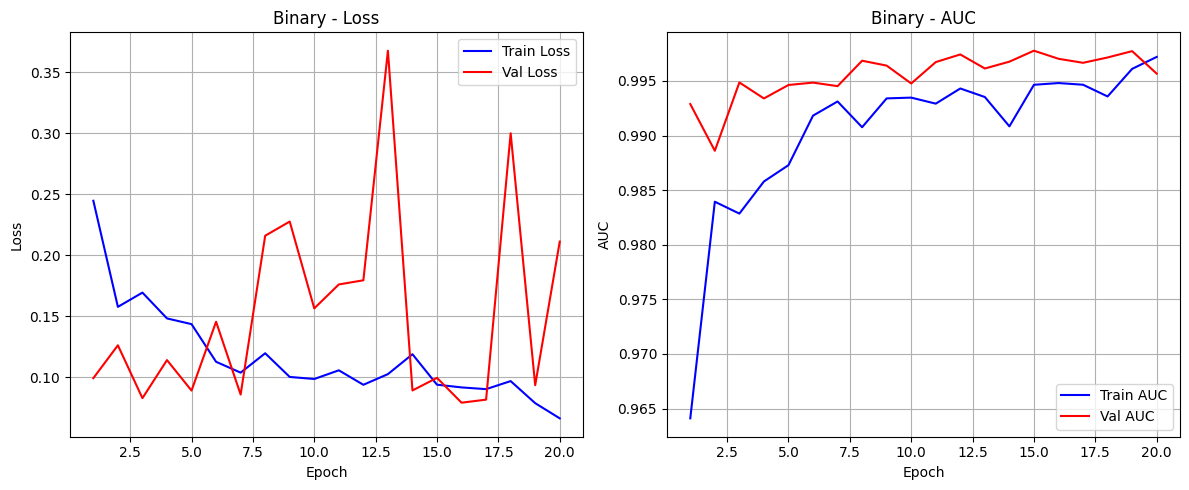

Plotting multiclass classification logs...
Loading logs from: c:\Dev\PneumoScope\results\multiclass\training_logs_multi_e22_20250113-081655.json


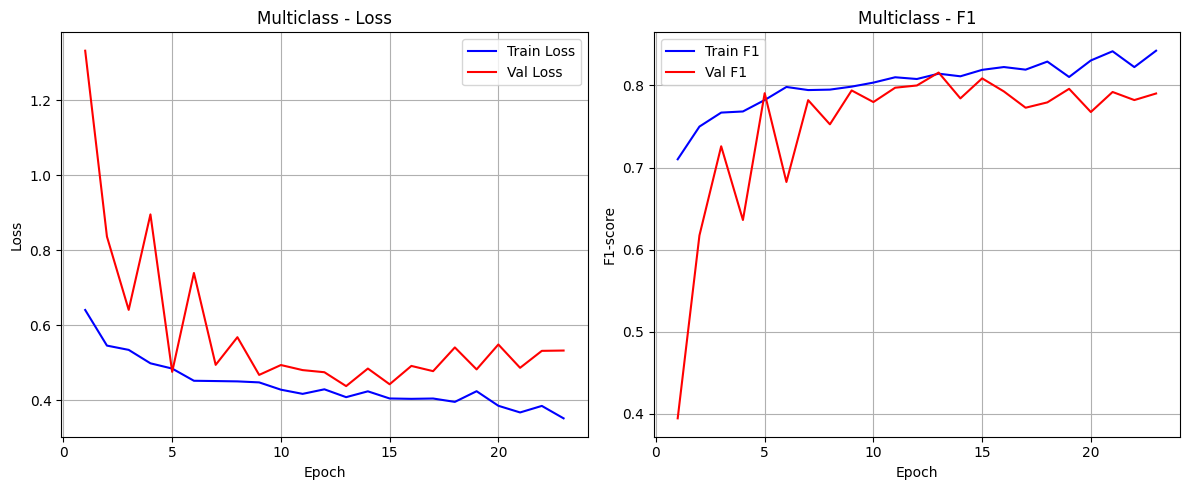

In [13]:
import json

def plot_training_logs(json_path, model_type='binary'):
    if not os.path.exists(json_path):
        print(f"[WARNING] {json_path} not found.")
        return

    print(f"Loading logs from: {json_path}")
    with open(json_path, 'r') as f:
        logs = json.load(f)
    df_logs = pd.DataFrame(logs)
    
    epochs = np.arange(1, len(df_logs['train_loss']) + 1)

    # Plot: training/validation loss
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, df_logs['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, df_logs['val_loss'], 'r-', label='Val Loss')
    plt.title(f"{model_type.capitalize()} - Loss")
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    # Plot: training/validation metric
    plt.subplot(1,2,2)
    if model_type == 'binary':
        plt.plot(epochs, df_logs['train_auc'], 'b-', label='Train AUC')
        plt.plot(epochs, df_logs['val_auc'], 'r-', label='Val AUC')
        plt.title(f"{model_type.capitalize()} - AUC")
        plt.ylabel('AUC')
    else:
        plt.plot(epochs, df_logs['train_f1'], 'b-', label='Train F1')
        plt.plot(epochs, df_logs['val_f1'], 'r-', label='Val F1')
        plt.title(f"{model_type.capitalize()} - F1")
        plt.ylabel('F1-score')
    plt.legend()
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

logs_bin_path = os.path.join(PROJECT_ROOT, "results", "training_logs_e19_b32_20250113-012235.json")
logs_multi_path = os.path.join(PROJECT_ROOT, "results", "multiclass", "training_logs_multi_e22_20250113-081655.json")

print("[NOTEBOOK] Plotting logs for binary and multiclass...")

if os.path.exists(logs_bin_path):
    print("Plotting binary classification logs...")
    plot_training_logs(logs_bin_path, model_type='binary')
else:
    print(f"Binary logs not found at: {logs_bin_path}")

if os.path.exists(logs_multi_path):
    print("Plotting multiclass classification logs...")
    plot_training_logs(logs_multi_path, model_type='multiclass')
else:
    print(f"Multiclass logs not found at: {logs_multi_path}")


## Extended Analysis

### Comparing Binary vs. Multiclass Results
- **Binary**: Often very high precision, recall, AUC. Simpler boundary (Normal vs. Pneumonia).  
- **Multiclass**: Macro-F1 around 0.78–0.82. Virus can be harder to classify (lowest recall).

### Overfitting vs. Underfitting
- **Binary**: Minimal gap between train and val metrics if tuned properly.  
- **Multiclass**: Training might reach ~0.80–0.85, val ~0.70–0.80 → mild overfitting.  

### Data Overlap
- Bacteria vs. virus confusion.  
- Underrepresented classes may lead to memorization issues.


## Grad-CAM Visualization & Further Analysis

Grad-CAM helps visualize where the model focuses on the image. This is crucial in medical imaging to verify that the model attends to lung regions (instead of textual stamps or corners).

We define transforms, labels, and Grad-CAM code below.

### Examples for class: NORMAL

c:\Dev\PneumoScope\.venv\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


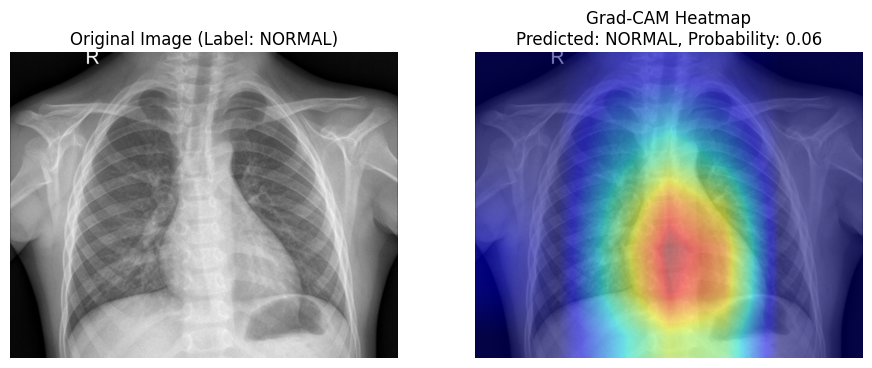

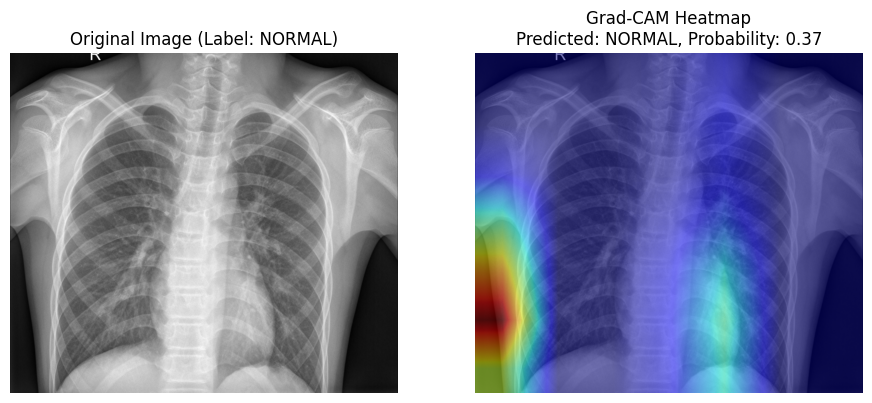

### Examples for class: PNEUMONIA

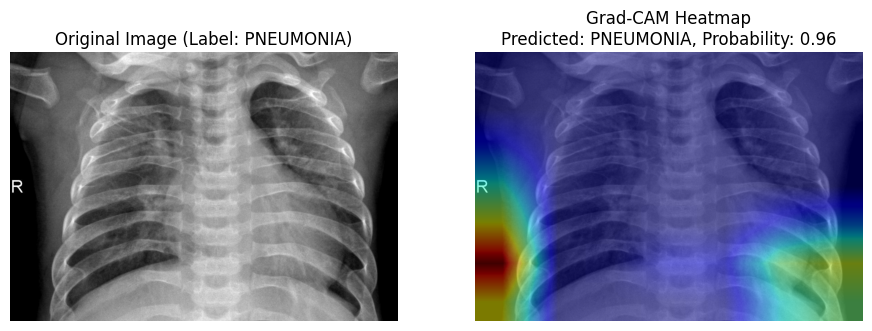

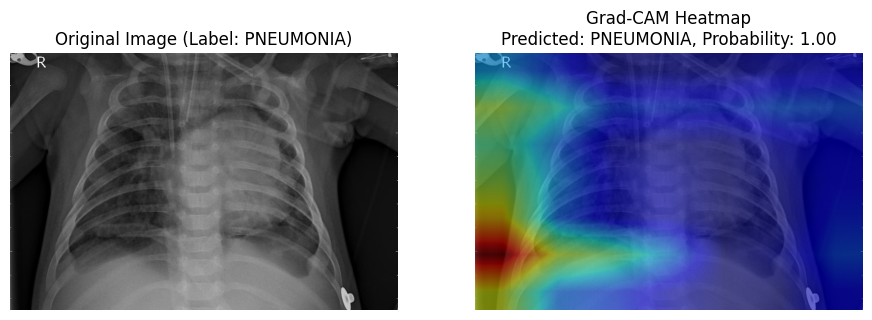

### Examples for class: NORMAL

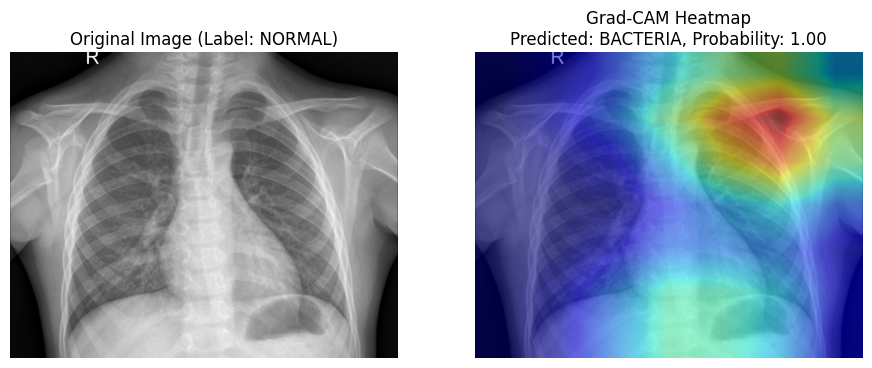

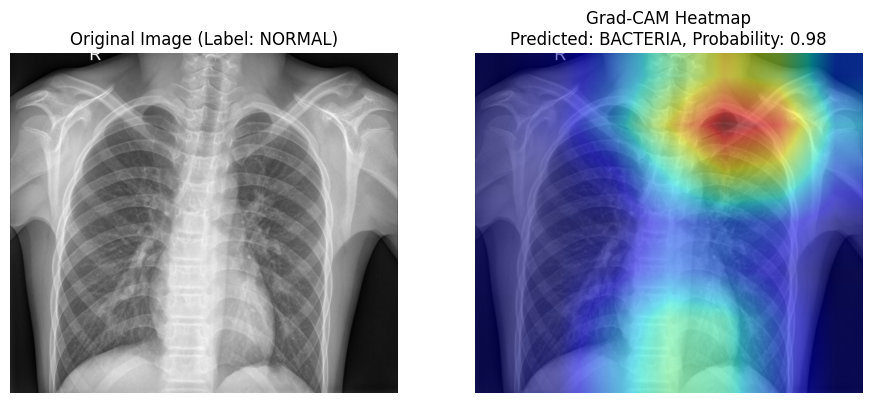

### Examples for class: BACTERIA

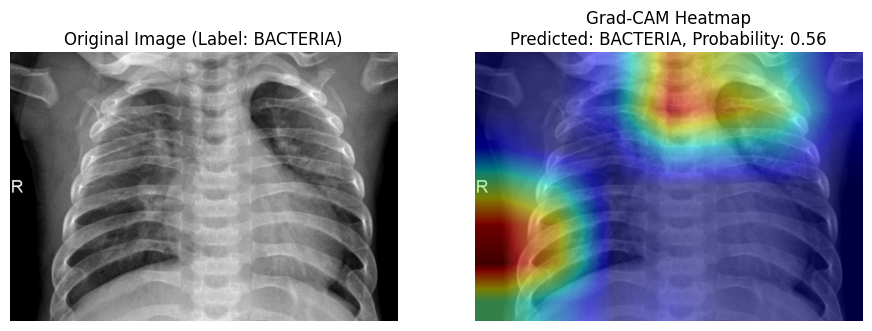

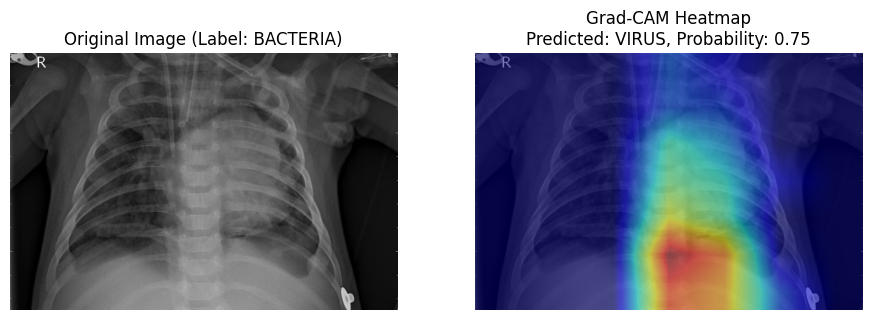

### Examples for class: VIRUS

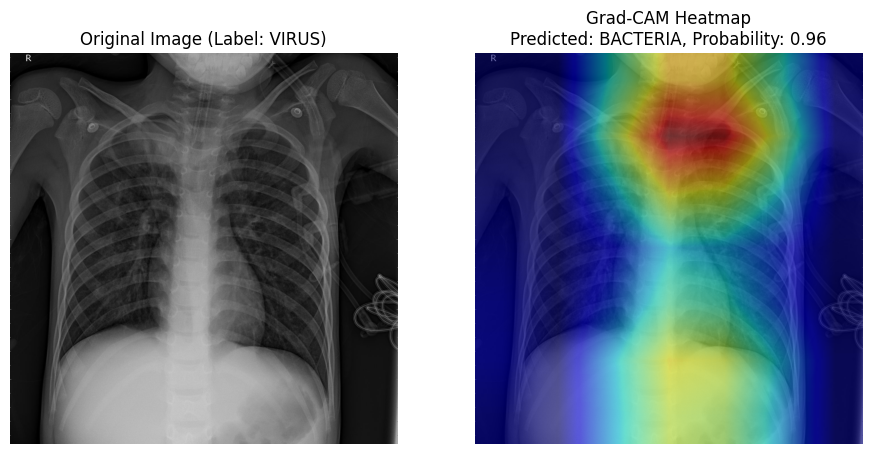

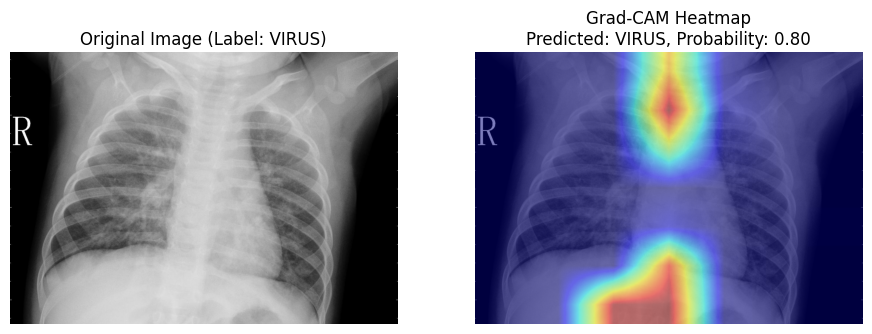

In [14]:
import torch
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from torchvision import transforms
from IPython.display import display, Markdown

# Same transforms as used in training
gradcam_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

BINARY_LABELS = {0: "NORMAL", 1: "PNEUMONIA"}
MULTI_LABELS = {0: "NORMAL", 1: "BACTERIA", 2: "VIRUS"}

activations = None

def register_hooks(model, model_type='binary'):
    """
    Registers forward and regular backward hooks on the last conv layer.
    Note: regular backward_hook might show a FutureWarning in newer PyTorch versions.
    """
    global activations
    gradients = []
    activations = None

    def forward_hook(module, input, output):
        global activations
        activations = output

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Choose the final conv layer depending on binary or multiclass
    if model_type == 'binary':
        target_layer = model.base_model.layer4[-1].conv2
    else:
        target_layer = model.model.layer4[-1].conv2

    # Clear any existing hooks
    if hasattr(target_layer, '_backward_hooks'):
        target_layer._backward_hooks.clear()
    if hasattr(target_layer, '_forward_hooks'):
        target_layer._forward_hooks.clear()

    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)
    return gradients

def compute_gradcam(image_path, model, transform, model_type='binary'):
    """
    Runs forward + backward pass to create a Grad-CAM heatmap.
    Returns (PIL image, heatmap array, predicted_class, probability, labels).
    """
    global activations
    device = next(model.parameters()).device
    gradients = register_hooks(model, model_type)

    labels = BINARY_LABELS if model_type == 'binary' else MULTI_LABELS

    # 1) Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    # 2) Forward pass
    output = model(input_tensor)

    # 3) Determine predicted class and probability
    if model_type == 'binary':
        probability = torch.sigmoid(output).item()
        predicted_class = 1 if probability >= 0.5 else 0
    else:
        probs = torch.softmax(output, dim=1).squeeze()
        predicted_class = probs.argmax().item()
        probability = probs[predicted_class].item()

    # 4) Backward pass on the logit
    model.zero_grad()
    if model_type == 'binary':
        output.backward()
    else:
        output[0, predicted_class].backward()

    # 5) Build Grad-CAM
    grad = gradients[0].cpu().numpy()              # shape [C, H, W]
    act = activations.detach().cpu().numpy()[0]    # shape [C, H, W]

    weights = np.mean(grad, axis=(1, 2))
    gradcam = np.zeros(act.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        gradcam += w * act[i]

    gradcam = np.maximum(gradcam, 0)
    max_val = gradcam.max()
    if max_val > 0:
        gradcam /= max_val
    else:
        gradcam[:] = 0

    gradcam = Image.fromarray(np.uint8(255 * gradcam)).resize(image.size, Image.BILINEAR)
    return image, np.array(gradcam), predicted_class, probability, labels

def visualize_gradcam(image_path, model, transform, true_label, model_type='binary', correct_prediction=None):
    """
    Loads an image -> computes Grad-CAM -> Visualizes in matplotlib.
    """
    image, gradcam, predicted_class, probability, labels = compute_gradcam(
        image_path, model, transform, model_type
    )

    # Create a colored heatmap from the grayscale Grad-CAM
    heatmap_colored = plt.cm.jet(gradcam / 255.0)[:, :, :3]
    heatmap_colored = np.uint8(255 * heatmap_colored)
    overlay = np.uint8(np.array(image) * 0.5 + heatmap_colored * 0.5)

    plt.figure(figsize=(11, 5.5))

    plt.subplot(1, 2, 1)
    plt.title(f"Original Image (Label: {labels[true_label]})")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    title = f"Grad-CAM Heatmap\nPredicted: {labels[predicted_class]}, Probability: {probability:.2f}"
    if correct_prediction is not None and not correct_prediction:
        title += " [WRONG]"
    plt.title(title)
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()

def analyze_model(model, transform, model_type='binary', samples_per_class=2):
    """
    Loops through a few examples per class from the test folder and shows Grad-CAM overlays.
    """
    model.eval()
    base_dir = "c:/Dev/PneumoScope/data/test"  # adjust if needed

    if model_type == 'binary':
        class_dirs = {
            0: os.path.join(base_dir, "NORMAL"),
            1: os.path.join(base_dir, "PNEUMONIA")
        }
    else:
        pneumonia_dir = os.path.join(base_dir, "PNEUMONIA")
        class_dirs = {
            0: os.path.join(base_dir, "NORMAL"),
            1: pneumonia_dir,  # Bacteria (filtered by filename)
            2: pneumonia_dir   # Virus (filtered by filename)
        }

    for label, directory in class_dirs.items():
        if not os.path.exists(directory):
            print(f"[WARN] Directory not found: {directory}")
            continue
        
        display(Markdown(f"### Examples for class: "
                         f"{BINARY_LABELS[label] if model_type == 'binary' else MULTI_LABELS[label]}"))

        if model_type == 'binary':
            images = os.listdir(directory)[:samples_per_class]
        else:
            all_images = os.listdir(directory)
            if label == 0:  # NORMAL
                images = all_images[:samples_per_class]
            elif label == 1:  # BACTERIA
                images = [img for img in all_images if 'bacteria' in img.lower()][:samples_per_class]
            else:  # VIRUS
                images = [img for img in all_images if 'virus' in img.lower()][:samples_per_class]

        for img_name in images:
            image_path = os.path.join(directory, img_name)
            visualize_gradcam(image_path, model, transform, label, model_type)

# Example calls - You can comment/uncomment as needed:
analyze_model(model_bin, gradcam_transform, 'binary')
analyze_model(model_multi, gradcam_transform, 'multi')


## Concluding Remarks
In this Notebook, we have:

1. Prepared the dataset for both binary and multiclass tasks, discussing data leakage concerns (patient-level splits, textual stamps).
2. Trained two different ResNet18-based models:
   - **Binary**: NORMAL vs. PNEUMONIA
   - **Multiclass**: NORMAL, BACTERIA, VIRUS
3. Evaluated both models, including metrics, confusion matrices, and Grad-CAM overlays.
4. Performed basic EDA to show dataset composition.
5. Observed Grad-CAM to see which regions the models attend to, noting potential leakage from text or corners.

### Differences Between Binary vs. Multiclass
- Binary often yields higher AUC and F1 due to a simpler decision boundary.
- Multiclass must distinguish between bacteria and virus, often lowering performance on the virus class.

### Overfitting vs. Underfitting
- If training metrics far exceed validation/test, we see overfitting.
- If both remain low, we see underfitting or insufficient training epochs.

### Further Work
- **Hyperparameter Tuning**: Use `hyperparameter_tuning.py` or frameworks like Optuna.
- **Enhanced Data Cleaning**: Mask text, randomize filenames, ensure patient-level splits.
- **Ethical & Practical Considerations**: Minimizing false negatives is critical in clinical settings.
- **Model Architecture**: We tested ResNet18; other networks (ResNet50, DenseNet, EfficientNet) may improve performance.
- **Weighted Sampling**: Especially for the multiclass scenario where virus might be underrepresented.

By combining these improvements, multiclass performance could move closer to the robust results seen in the binary classifier.


# Inference Process

**Run the Flask App:**  
Use the `app.py` script to start the Flask web application for real-time predictions:

```bash
python app.py
```

**Upload and Classify Images:**  
Open your web browser and go to [http://127.0.0.1:5000/](http://127.0.0.1:5000/). Upload a chest X-ray image to classify it as "Normal" or "Pneumonia".

The inference process involves using the trained model to make predictions on new chest X-ray images. Here is a summary of how the inference works:

**Load the Trained Model:**  
The trained model is loaded from a saved checkpoint file. The model's weights are restored to the state they were in after training.

**Preprocess the Input Image:**  
The input image is preprocessed to match the format expected by the model. This includes resizing the image, converting it to a tensor, and normalizing the pixel values.

**Perform Inference:**  
The preprocessed image is passed through the model to obtain the output logits. For binary classification, the logits are converted to probabilities using the sigmoid function. A threshold is applied to determine the final prediction (e.g., 0.5 for binary classification).
